In [1]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import textalloc as ta
import os

os.chdir("../")

from epitools import get_data

In [2]:
country, year, election, aggregation = "Chile", 2021, "first_round", "region_id"
# country, year, election, aggregation = "France", 2022, "first_round", "nuts_2"
# country, year, election, aggregation = "Peru", 2021, "first_round", "region"

df = pd.read_csv(f"data_output/{country}/{year}_{election}.csv.gz")
df_location = pd.read_csv(f"data_output/{country}/{year}_{election}_location.csv.gz")
df = pd.merge(df, df_location, on="polling_id")

df["abstention"] = (df["candidate"] == "ABSTENTION").astype(int)

df_ep = get_data(
    country=country,
    year=year,
    aggregation=aggregation,
    election=election
)

if country == "Chile":
    df_ep[aggregation] = df_ep[aggregation].astype(int)

df.head()

,polling_id,candidate,value,rate,rank,flag_candidates,region_id,region,province,senate_district,district,commune,electoral_circ,polling_place,polling_table,polling_type,mixed_polling,voters,abstention
0,ALGARROBO-ALGARROBO-1.0-M-1M,EDUARDO ARTES BRICHETTI,1.0,0.006024,7.0,1,5,DE VALPARAISO,SAN ANTONIO,6,7,ALGARROBO,ALGARROBO,LICEO TECNICO CARLOS ALESSANDRI ALTAMIRANO LOC...,1,M,1M,339,0
1,ALGARROBO-ALGARROBO-1.0-M-1M,FRANCO PARISI FERNANDEZ,14.0,0.084337,5.0,1,5,DE VALPARAISO,SAN ANTONIO,6,7,ALGARROBO,ALGARROBO,LICEO TECNICO CARLOS ALESSANDRI ALTAMIRANO LOC...,1,M,1M,339,0
2,ALGARROBO-ALGARROBO-1.0-M-1M,GABRIEL BORIC FONT,29.0,0.174699,3.0,1,5,DE VALPARAISO,SAN ANTONIO,6,7,ALGARROBO,ALGARROBO,LICEO TECNICO CARLOS ALESSANDRI ALTAMIRANO LOC...,1,M,1M,339,0
3,ALGARROBO-ALGARROBO-1.0-M-1M,JOSE ANTONIO KAST RIST,53.0,0.319277,1.0,1,5,DE VALPARAISO,SAN ANTONIO,6,7,ALGARROBO,ALGARROBO,LICEO TECNICO CARLOS ALESSANDRI ALTAMIRANO LOC...,1,M,1M,339,0
4,ALGARROBO-ALGARROBO-1.0-M-1M,MARCO ENRIQUEZ-OMINAMI GUMUCIO,10.0,0.060241,6.0,1,5,DE VALPARAISO,SAN ANTONIO,6,7,ALGARROBO,ALGARROBO,LICEO TECNICO CARLOS ALESSANDRI ALTAMIRANO LOC...,1,M,1M,339,0


In [3]:
data = df.groupby([aggregation, "abstention"]).agg({"value": "sum"})
data["share"] = data.groupby(level=[0], group_keys=False).apply(lambda x: x/x.sum())
data = data.query("abstention == 0").reset_index()

data = pd.merge(data, df_ep, on=aggregation)
if country == "France":
    data = data[(~data[aggregation].str.contains("FRY")) & (~data[aggregation].str.contains("FRM"))]

for col in ["ec", "ep"]:
    data[col] = (data[col] - data[col].mean()) / data[col].std()

data["value"] = data["value"].apply(lambda x: np.power(x, 2))
data.head()

,region_id,abstention,value,share,ec,ep,year
0,1,0,1.217801e+10,0.424199,-1.233207,0.524055,2021
1,2,0,4.154993e+10,0.423076,-0.971260,0.252306,2021
2,3,0,1.148862e+10,0.441492,-0.769752,1.501224,2021
3,4,0,7.129701e+10,0.428197,1.470655,0.294473,2021
4,5,0,6.447705e+11,0.497929,0.663154,0.466801,2021


C:\Users\cnava\AppData\Local\Temp\ipykernel_18292\3028380865.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{int(x*100)}%" for x in ax.get_xticks()])


Text(0, 0.5, 'Election Competitiveness (Standardized)')

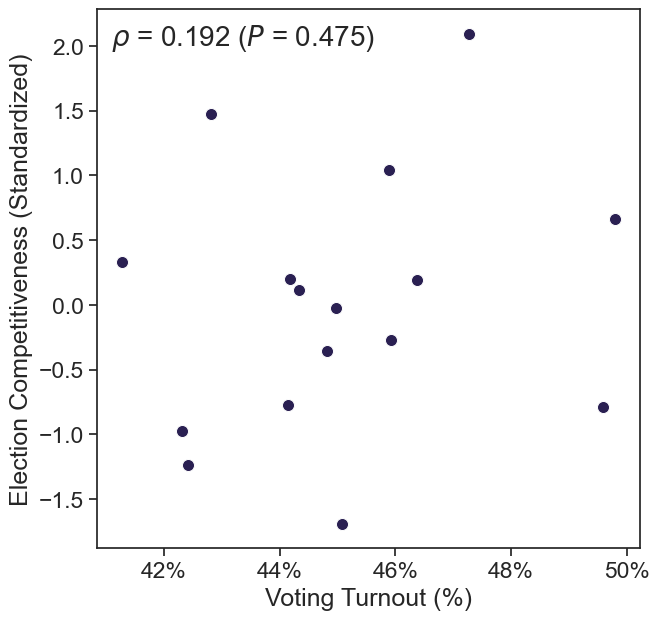

: 

In [4]:
sns.set(font_scale=1.5, style="ticks")
fig, ax = plt.subplots(figsize=(7, 7), dpi=100)
color = "#2A2052"

sns.scatterplot(x="share", y="ec", s=75, color=color, data=data)

ax.set_xticklabels([f"{int(x*100)}%" for x in ax.get_xticks()])

corr, pvalue = pearsonr(data["share"], data["ec"])
def corrfunc(pvalue):
    if pvalue < 0.001:
        return "$P$ < 0.001"
    else:
        return f"$P$ = {round(pvalue, 3)}"

labels = {"ec": "EC", "ep": "EP"}
val = corrfunc(pvalue)

pos = 0.975
ax.text(0.025, pos, f"$ρ$ = {round(corr, 3)} ({val})", transform=ax.transAxes, va="top", fontsize=20)
pos -= 0.05
# x, y, z = [], [], []
# for i, row in data.iterrows():
#     x.append(row["share"])
#     y.append(row["ec"])
#     if country == "Chile":
#         z.append(int(row[aggregation]))
#     else:
#         z.append(row[aggregation])

#     ta.allocate_text(
#         fig,ax,x,y,z,
#         x_scatter=x, 
#         y_scatter=y, 
#         textsize=16, 
#         linecolor=color,
#         weight=400
#     )

ax.set_xlabel("Voting Turnout (%)")
ax.set_ylabel("Election Competitiveness (Standardized)")
